# Exemplo 13: Reconhecimento de Imagens e Augmentação usando Tensorflow e Keras

## Exemplo reconhecimento de espécies de flores

Um dos problemas clássicos de Aprendizado Profundo (Deep Learning) usando Redes Neurais Convolucionais (CNNs) é a identificação de flores. A partir de uma base com 4500 imagens JPEG de 5 espécies de flores com cores, tamanhos e ângulos diferentes podemos identificar a qual espécie uma foto de flor qualquer pode ser classificada.   

Este exemplo mostra uma forma usual de organização de classificação de imagens. As imagens já classificadas são colocadas em diretórios diferentes com o nome da espécie. O programa inicialmente lê um diretório de imagens, cria um vetor de features e inclui um tag de identificação igual ao nome do diretório. Cada diretório pode comnter qualquer numero de imagens, no entanto, é obrigatório que cada diretório possua apenas uma categoria de imagem.

Aumento de dados (em inglês, augmentation) é uma técnica usada para expandir ou ampliar o conjunto de dados para treinamento do modelo usando variações dos dados existentes. Para isso, aplicamos diferentes técnicas para expandir nosso conjunto de dados de modo que ajude a treinar melhor nosso modelo com um conjunto de dados maior. O aumento de imagem (image augmentation) é uma das técnicas que podemos aplicar em um conjunto de dados de imagem para expandir nosso conjunto de dados de forma que reduza o overfitting em nosso modelo. As técnicas mais comuns são deslocar a imagem, espelhar horizontal e verticalmente, aplicar zoom e variar contraste. Essa técnica deve ser usada com cuidado, pois seu uso pode piorar a acurácia além de aumentar o tempo de processamento.

A base de dados é separada em base de treinamento e base de validação (teste). A rede é treinada com a base de treinamento e a base de validação avalia a acurácia de cada modelo utilizado e o tempo de treinamento é medido.

O primeiro modelo é o simples, com poucas camadas. O segundo é o modelo complexo com 18 camadas. Depois usaremos redes pré-treinadas. A técnica chamada aprendizagem de transferência, onde uma rede pré-treinada (treinada com cerca de um milhão de imagens genericas), é usada para extrair atributos e treinar uma nova camada no topo para classificar as imagens de flores.

No final é apresentado uma tabela comparando a acurácia e tempo de processamento do treinamento de cada modelo.

In [1]:
# Load libs
import os, pathlib, logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
from time import perf_counter

import tensorflow as tf
from tensorflow.keras import layers, models, utils
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import IPython.display as display
import numpy as np
import matplotlib.pyplot as plt

physical_devices = tf.config.list_physical_devices('GPU')
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")
print("Num GPUs:", len(physical_devices))
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
  print("GPU mem growth set")
except:
  print("Failed to set GPU mem growth")
  pass

print("Tensorflow version:", tf.__version__)
from tensorflow.python.platform import build_info as build
print(f"Cuda Version: {build.build_info['cuda_version']}")
print(f"Cudnn version: {build.build_info['cudnn_version']}")
tf.distribute.OneDeviceStrategy(device="/GPU:0")
AUTOTUNE = tf.data.experimental.AUTOTUNE

GPU is available
Num GPUs: 1
GPU mem growth set
Tensorflow version: 2.16.1
Cuda Version: 12.3
Cudnn version: 8


## Set hyperparameters

In [2]:
# Set hyperparameters
VAL_SAMPLE = 0.2
BATCH_SIZE = 50
SHUFFLE_BUFFER = 1000
IMG_HEIGHT = 224
IMG_WIDTH = 224
EPOCHS=5

# Set main images directory
data_repo = "/data/dataset/flower_photos/"

# Set base directory (where are all flower's directories)
data_dir = pathlib.Path(data_repo)
print(data_dir)

/data/dataset/flower_photos


## Bibliotecas úteis

In [3]:
# Print some flowers
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(20):
        ax = plt.subplot(5,5,n+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')
    plt.show()

## Leitura images do repositorio

In [4]:
# Estrutura dos diretorios
#
# data_repo / dandelion  / image_x.jpg ... 
#           / daisy      / image_x.jpg ...
#           / sunflower  / image_x.jpg ...
#           / rose       / image_x.jpg ...
#           / tulip      / image_x.jpg ...

# Count the number of flower images and set dataset size
SIZE_OF_DATASET = len(list(data_dir.glob('*/*.jpg')))

print("Number of images: ",SIZE_OF_DATASET)

Number of images:  4510


In [5]:
# Get the Class names reading directory names
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
print(CLASS_NAMES)

['dandelion' 'daisy' 'sunflower' 'rose' 'tulip']


## Image Processing and Augmentation

In [6]:
#Set start time for prepare images
start_time = perf_counter()

# Configuring Image generator to execute image augmentation in training data
train_datagen = ImageDataGenerator(
    validation_split=VAL_SAMPLE,    # Split validation data
    rescale=1./255,                  # scale images from integers 0-255 to floats 0-1.
#    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
#    width_shift_range=0.2,
#    height_shift_range=0.2,
#    horizontal_flip=True 
)

# Configuring Image generator to rescale image in validation data (they dont need augmentation)
val_datagen = ImageDataGenerator(
    validation_split=VAL_SAMPLE,  # Split validation data
    rescale=1./255,                # scale images from integers 0-255 to floats 0-1.
)

In [7]:
# Create augmented training dataset reading images from directory
train_ds = train_datagen.flow_from_directory(
    data_dir,                            # directory name in format class/images.jpg
    class_mode='categorical',            # classe type
    color_mode='rgb',                    # 'grayscale', 'rgb', 'rgba' 
    subset="training",                   # define train dataset
    seed=123,
    target_size=(IMG_HEIGHT, IMG_WIDTH), # output image size
    classes = list(CLASS_NAMES),         # list of classes names
    shuffle=True,                        # Set shuffle
    batch_size=BATCH_SIZE                # Batch size
)

Found 3609 images belonging to 5 classes.


In [8]:
# Create validation dataset reading images from directory
val_ds = val_datagen.flow_from_directory(
    data_dir,                            # directory name in format class/images.jpg
    class_mode='categorical',            # classe type
    color_mode='rgb',                    # 'grayscale', 'rgb', 'rgba' 
    subset="validation",                 # define validation dataset
    seed=123,
    target_size=(IMG_HEIGHT, IMG_WIDTH), # output image size
    classes = list(CLASS_NAMES),         # list of classes names
    shuffle=True,                        # Set shuffle
    batch_size=BATCH_SIZE                # Batch size
)

Found 901 images belonging to 5 classes.


In [9]:
# Calculate train and validation step
#STEP_SIZE_TRAIN=train_ds.n//train_ds.batch_size
#STEP_SIZE_VALID=val_ds.n//val_ds.batch_size

In [10]:
time_ip = perf_counter() - start_time
tf.print("Image processing time: ", time_ip, "s")

Image processing time:  0.8949572050041752 s


(50, 224, 224, 3) (50, 5)


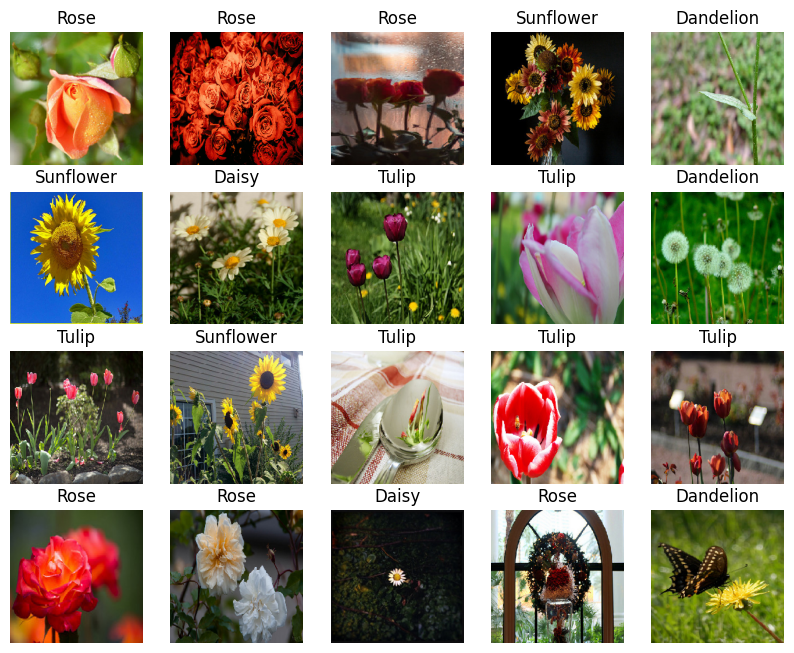

In [11]:
# Print some images with label
images, labels = next(val_ds)
print(images.shape, labels.shape)
show_batch(images, labels)

# Create Convolutional Neural Network (CNN) Model

## Simple Model

In [12]:
start_time = perf_counter()

model = models.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(5, activation='relu'),
    layers.Dense(5)
], name = 'Simple_Model')

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              jit_compile=True,
              metrics=['accuracy'])

model.summary()

Model: "Simple_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │       250,885 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            30 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 274,499 (1.05 MB)

 Trainable params: 274,499 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1719422895.713122 2746625 service.cc:145] XLA service 0x7fa9cc004a00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719422895.713172 2746625 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9


 1/73 ━━━━━━━━━━━━━━━━━━━━ 33:01 28s/step - accuracy: 0.2600 - loss: 1.6059

I0000 00:00:1719422899.203033 2746625 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


73/73 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.2606 - loss: 1.6075 - val_accuracy: 0.3629 - val_loss: 1.5040
Epoch 2/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 56s 700ms/step - accuracy: 0.3391 - loss: 1.5203 - val_accuracy: 0.3873 - val_loss: 1.4530
Epoch 3/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 56s 693ms/step - accuracy: 0.3785 - loss: 1.4395 - val_accuracy: 0.3896 - val_loss: 1.3666
Epoch 4/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 56s 695ms/step - accuracy: 0.3957 - loss: 1.3526 - val_accuracy: 0.3873 - val_loss: 1.3562
Epoch 5/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 56s 699ms/step - accuracy: 0.4223 - loss: 1.3133 - val_accuracy: 0.4606 - val_loss: 1.2888


### Evaluating the Simple CNN Model Performance

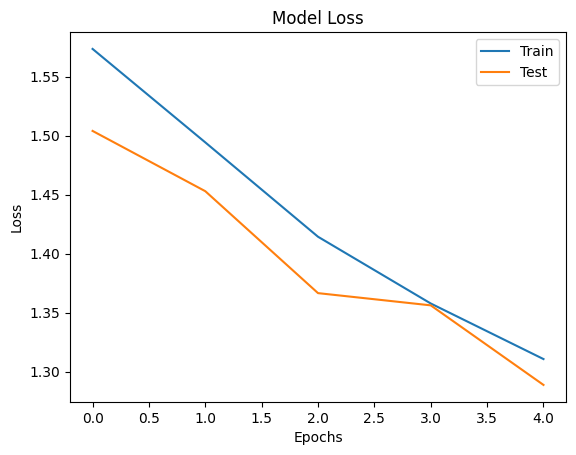

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

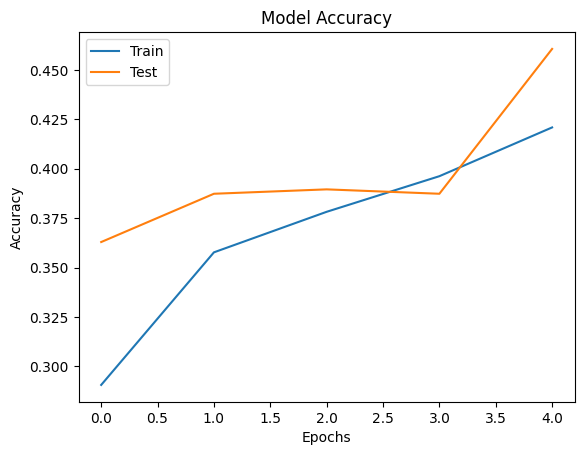

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

In [16]:
train_loss_sm, train_acc_sm = model.evaluate(train_ds, batch_size=BATCH_SIZE)
test_loss_sm, test_acc_sm = model.evaluate(val_ds, batch_size=BATCH_SIZE)
time_sm = perf_counter() - start_time
print(time_sm)

73/73 ━━━━━━━━━━━━━━━━━━━━ 53s 723ms/step - accuracy: 0.4520 - loss: 1.2613
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - accuracy: 0.4479 - loss: 1.3051
480.6754255350097


## Complex Model 

In [17]:
start_time = perf_counter()

model = models.Sequential([
# layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    layers.Conv2D(32, (3,3), padding='same', activation='relu', name='conv_1'),
    layers.Conv2D(32, (3,3), activation='relu', name='conv_2'),
    layers.MaxPooling2D(pool_size=(2,2), name='maxpool_1'),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3,3), padding='same', activation='relu', name='conv_3'),
    layers.Conv2D(64, (3,3), activation='relu', name='conv_4'),
    layers.MaxPooling2D(pool_size=(2,2), name='maxpool_2'),
    layers.Dropout(0.25),
    layers.Conv2D(128, (3,3), padding='same', activation='relu', name='conv_5'),
    layers.Conv2D(128, (3,3), activation='relu', name='conv_6'),
    layers.MaxPooling2D(pool_size=(2,2), name='maxpool_3'),
    layers.Flatten(),
    layers.Dense(512, activation='relu', name='dense_1'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', name='dense_2'),
    layers.Dense(len(CLASS_NAMES), name='output'),
    layers.Activation('softmax')
], name = 'Complex_Model')

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              jit_compile=True,
              metrics=['accuracy'])

model.summary()

Model: "Complex_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 222, 222, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling2D)        │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 111, 111, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 109, 109, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_2 (MaxPooling2D)        │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5 (Conv2D)                 │ (None, 54, 54, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_6 (Conv2D)                 │ (None, 52, 52, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_3 (MaxPooling2D)        │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │           645 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,656,165 (170.35 MB)

 Trainable params: 44,656,165 (170.35 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

Epoch 1/5
72/73 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - accuracy: 0.2912 - loss: 1.6273

I0000 00:00:1719423424.869170 2762612 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_101', 4 bytes spill stores, 4 bytes spill loads



73/73 ━━━━━━━━━━━━━━━━━━━━ 83s 835ms/step - accuracy: 0.2930 - loss: 1.6230 - val_accuracy: 0.4062 - val_loss: 1.2557
Epoch 2/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 56s 695ms/step - accuracy: 0.4525 - loss: 1.2670 - val_accuracy: 0.5250 - val_loss: 1.1294
Epoch 3/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 57s 702ms/step - accuracy: 0.5350 - loss: 1.1430 - val_accuracy: 0.5461 - val_loss: 1.0660
Epoch 4/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 56s 699ms/step - accuracy: 0.5614 - loss: 1.0644 - val_accuracy: 0.5805 - val_loss: 1.0060
Epoch 5/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 56s 698ms/step - accuracy: 0.5810 - loss: 1.0245 - val_accuracy: 0.5705 - val_loss: 1.0426


### Evaluating the Complex CNN Model Performance

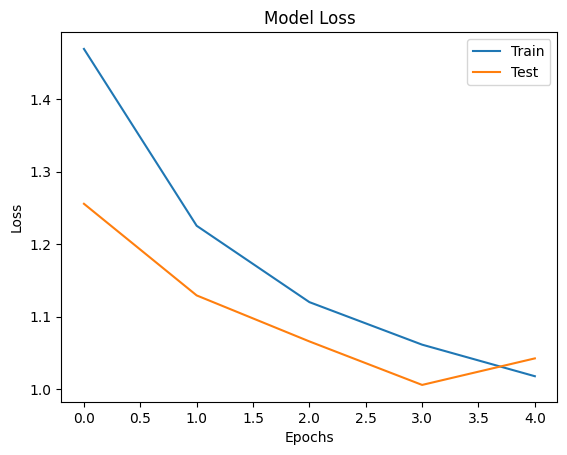

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

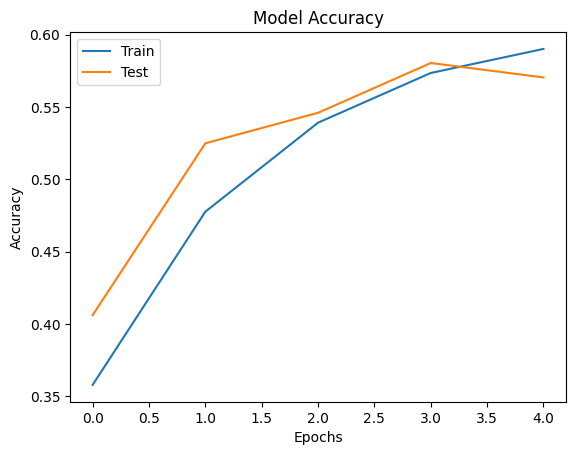

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

In [21]:
train_loss_cm, train_acc_cm = model.evaluate(train_ds, batch_size=BATCH_SIZE)
test_loss_cm, test_acc_cm = model.evaluate(val_ds, batch_size=BATCH_SIZE)
time_cm = perf_counter() - start_time
print(time_cm)

73/73 ━━━━━━━━━━━━━━━━━━━━ 54s 737ms/step - accuracy: 0.6135 - loss: 0.9595
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - accuracy: 0.5915 - loss: 1.0107
368.6943305159948


## Transfer Learning: VGG19 Pre-trained Model

In [22]:
start_time = perf_counter()

pre_trained_model = VGG19(input_shape=(IMG_HEIGHT, IMG_WIDTH ,3), include_top=False, weights="imagenet")

#pre_trained_model.trainable = False
for layer in pre_trained_model.layers[:19]:
    layer.trainable = False

# creating the final model  
model = models.Sequential([
    pre_trained_model,
    layers.MaxPool2D((2,2) , strides = 2),
    layers.Flatten(),
    layers.Dense(len(CLASS_NAMES) , activation='softmax')
], name = 'VGG19_Model')

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

Model: "VGG19_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ ?                      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 4,719,616 (18.00 MB)

 Non-trainable params: 15,304,768 (58.38 MB)

In [23]:
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

Epoch 1/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 63s 672ms/step - accuracy: 0.4568 - loss: 1.4951 - val_accuracy: 0.7248 - val_loss: 0.7378
Epoch 2/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 56s 703ms/step - accuracy: 0.7800 - loss: 0.6299 - val_accuracy: 0.8058 - val_loss: 0.5635
Epoch 3/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 56s 709ms/step - accuracy: 0.8366 - loss: 0.4455 - val_accuracy: 0.8091 - val_loss: 0.5293
Epoch 4/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 56s 701ms/step - accuracy: 0.8580 - loss: 0.3880 - val_accuracy: 0.8291 - val_loss: 0.5062
Epoch 5/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 56s 692ms/step - accuracy: 0.8961 - loss: 0.2925 - val_accuracy: 0.8224 - val_loss: 0.5810


### Evaluating the VGG19 CNN Model Performance

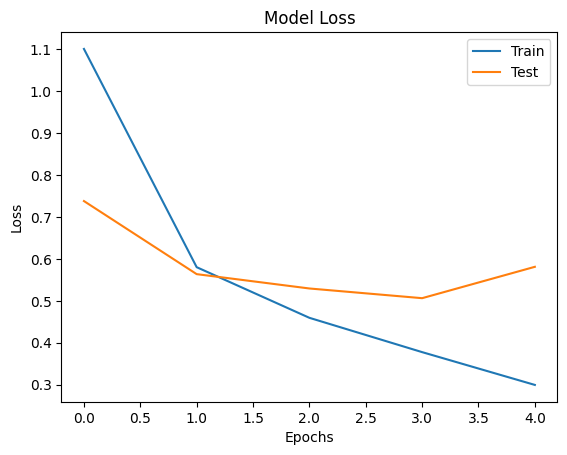

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

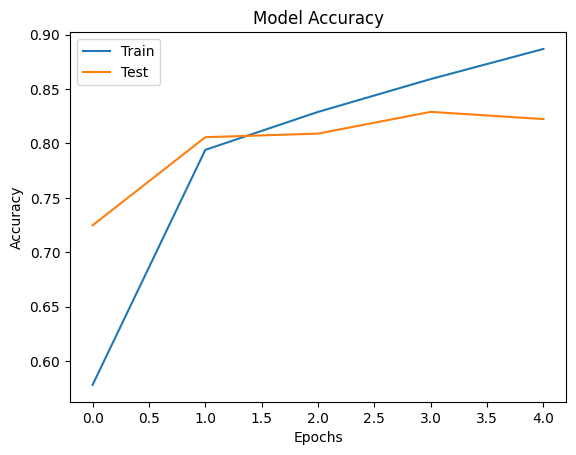

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

In [26]:
train_loss_vg, train_acc_vg = model.evaluate(train_ds, batch_size=BATCH_SIZE)
test_loss_vg, test_acc_vg = model.evaluate(val_ds, batch_size=BATCH_SIZE)
time_vg = perf_counter() - start_time
print(time_vg)

73/73 ━━━━━━━━━━━━━━━━━━━━ 53s 723ms/step - accuracy: 0.9089 - loss: 0.2602
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.8318 - loss: 0.5518
349.68858567600546


## Transfer Learning: ResNet50 Pre-trained Model

In [27]:
start_time = perf_counter()

pre_trained_model = ResNet50(include_top=False, pooling='avg')

model = models.Sequential([
    pre_trained_model,
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(len(CLASS_NAMES), activation='softmax')
], name = 'ResNet50_Model')

model.layers[0].trainable = False

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              jit_compile=True,
              metrics=['accuracy'])

model.summary()

Model: "ResNet50_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [28]:
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

Epoch 1/5


I0000 00:00:1719424085.296748 2781146 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5615', 244 bytes spill stores, 244 bytes spill loads

I0000 00:00:1719424085.314990 2781142 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5865', 444 bytes spill stores, 444 bytes spill loads

I0000 00:00:1719424085.570930 2781150 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5622', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1719424085.760287 2781141 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5615', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1719424086.359675 2781139 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5865', 436 bytes spill stores, 436 bytes spill loads

I0000 00:00:1719424086.39020

62/73 ━━━━━━━━━━━━━━━━━━━━ 6s 617ms/step - accuracy: 0.2679 - loss: 1.7018

I0000 00:00:1719424133.726739 2782522 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5622', 460 bytes spill stores, 348 bytes spill loads



73/73 ━━━━━━━━━━━━━━━━━━━━ 81s 790ms/step - accuracy: 0.2736 - loss: 1.6840 - val_accuracy: 0.3341 - val_loss: 1.5860
Epoch 2/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 56s 698ms/step - accuracy: 0.3588 - loss: 1.5287 - val_accuracy: 0.4140 - val_loss: 1.4405
Epoch 3/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 56s 695ms/step - accuracy: 0.3580 - loss: 1.4978 - val_accuracy: 0.3640 - val_loss: 1.4253
Epoch 4/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 56s 696ms/step - accuracy: 0.3894 - loss: 1.4623 - val_accuracy: 0.4484 - val_loss: 1.3632
Epoch 5/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 56s 698ms/step - accuracy: 0.3906 - loss: 1.4559 - val_accuracy: 0.4573 - val_loss: 1.3525


### Evaluating the Resnet CNN Model Performance

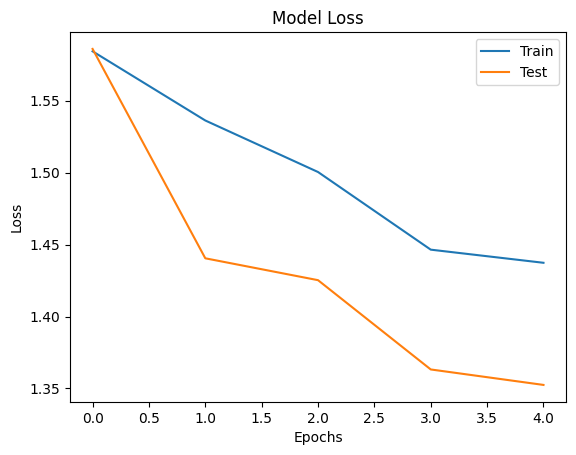

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

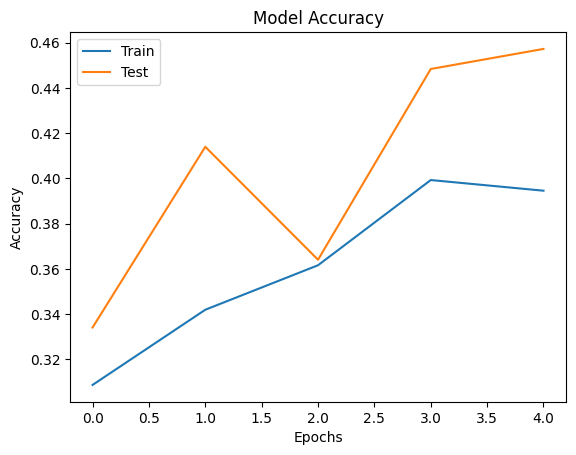

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

In [31]:
train_loss_rn, train_acc_rn = model.evaluate(train_ds, batch_size=BATCH_SIZE)
test_loss_rn, test_acc_rn = model.evaluate(val_ds, batch_size=BATCH_SIZE)
time_rn = perf_counter() - start_time
print(time_rn)

73/73 ━━━━━━━━━━━━━━━━━━━━ 54s 743ms/step - accuracy: 0.4193 - loss: 1.3995
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - accuracy: 0.4698 - loss: 1.3216
369.6557662989944


## Transfer Learning: InceptionV3 Pre-trained Model 

In [32]:
start_time = perf_counter()

pre_trained_model = InceptionV3(include_top=False, weights="imagenet", pooling='avg', classifier_activation='softmax')

model = models.Sequential([
    pre_trained_model,
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(len(CLASS_NAMES), activation='softmax')
], name = 'InceptionV3_Model')

model.layers[0].trainable = False

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

Model: "InceptionV3_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ ?                      │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [33]:
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

Epoch 1/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 91s 946ms/step - accuracy: 0.6124 - loss: 1.0514 - val_accuracy: 0.8091 - val_loss: 0.5441
Epoch 2/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 56s 697ms/step - accuracy: 0.8301 - loss: 0.4677 - val_accuracy: 0.8224 - val_loss: 0.4973
Epoch 3/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 57s 705ms/step - accuracy: 0.8623 - loss: 0.3818 - val_accuracy: 0.8202 - val_loss: 0.4925
Epoch 4/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 56s 698ms/step - accuracy: 0.8754 - loss: 0.3472 - val_accuracy: 0.8402 - val_loss: 0.4532
Epoch 5/5
73/73 ━━━━━━━━━━━━━━━━━━━━ 56s 696ms/step - accuracy: 0.8884 - loss: 0.3018 - val_accuracy: 0.8435 - val_loss: 0.4649


### Evaluating the InceptionV3 CNN Model Performance

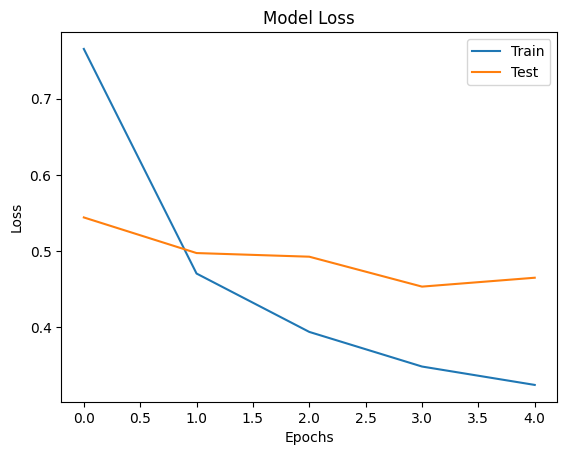

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

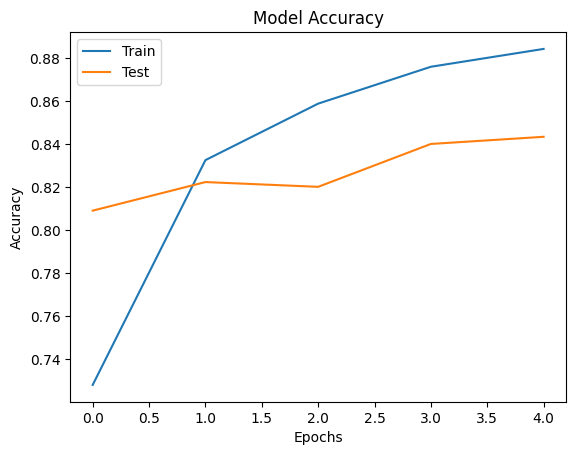

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

In [36]:
#train_loss_iv, train_acc_iv 
train_loss_iv, train_acc_iv = model.evaluate(train_ds, batch_size=BATCH_SIZE)
test_loss_iv, test_acc_iv = model.evaluate(val_ds, batch_size=BATCH_SIZE)
time_iv = perf_counter() - start_time
print(time_iv)

73/73 ━━━━━━━━━━━━━━━━━━━━ 56s 773ms/step - accuracy: 0.8928 - loss: 0.2706
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.8460 - loss: 0.4727
383.8353907529963


## Sumary  

In [37]:
print("===========================================================================")
print("===============  Compare CNN Algorithms Acurancy and Time =================")
print()
print("   Dataset size = ",SIZE_OF_DATASET,"   Train sample = ",(1-VAL_SAMPLE)*100,"%  Test sample = ",VAL_SAMPLE*100,"%")
print("   Image size: (%d,%d)   Batch size = %d         Epochs = %d        " % (IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE, EPOCHS))
print()
print("Processing images:                                          time = %3.1f s" % (time_ip))
print("Simple Model:         train_acc = %1.2f    test_acc = %1.2f   time = %3.1f s" % (train_acc_sm, test_acc_sm, time_sm))
print("Complex Model:        train_acc = %1.2f    test_acc = %1.2f   time = %3.1f s" % (train_acc_cm, test_acc_cm, time_cm))
print("VGG19:                train_acc = %1.2f    test_acc = %1.2f   time = %3.1f s" % (train_acc_vg, test_acc_vg, time_vg))
print("ResNet50:             train_acc = %1.2f    test_acc = %1.2f   time = %3.1f s" % (train_acc_rn, test_acc_rn, time_rn))
print("InceptionV3:          train_acc = %1.2f    test_acc = %1.2f   time = %3.1f s" % (train_acc_iv, test_acc_iv, time_iv))
print("===========================================================================")

===============  Compare CNN Algorithms Acurancy and Time =================

   Dataset size =  4510    Train sample =  80.0 %  Test sample =  20.0 %
   Image size: (224,224)   Batch size = 50         Epochs = 5        

Processing images:                                          time = 0.9 s
Simple Model:         train_acc = 0.46    test_acc = 0.46   time = 480.7 s
Complex Model:        train_acc = 0.61    test_acc = 0.57   time = 368.7 s
VGG19:                train_acc = 0.90    test_acc = 0.82   time = 349.7 s
ResNet50:             train_acc = 0.42    test_acc = 0.46   time = 369.7 s
InceptionV3:          train_acc = 0.89    test_acc = 0.84   time = 383.8 s
